In [1]:
# Manually upload zipped folder and unzip (also renamed it to image-datasets)
!unzip /content/image-datasets.zip

Archive:  /content/image-datasets.zip
replace __MACOSX/._image-datasets? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
import requests, re, time
import torch, torchvision

from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from torch.utils.mobile_optimizer import optimize_for_mobile

In [3]:
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full = datasets.ImageFolder('/content/image-datasets', transform=xform)

In [5]:
# In case we need more data:

#RandomGrayscale and RandomHorizontalFlip used here (but final probability decided on - after testing - is 1):
yform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomGrayscale(1), transforms.RandomHorizontalFlip(1)])
dataset_full += datasets.ImageFolder('/content//image-datasets', transform=yform)

In [7]:
len(dataset_full)

2252

In [8]:
# Sanity check:
dataset_full[0][0].shape

torch.Size([3, 224, 224])

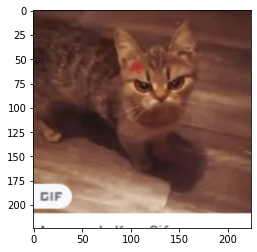

In [9]:
# Checking contents:
plt.imshow(dataset_full[46][0].permute(1,2,0))

Labels for angry=0;
happy=1;
sad=2;
sleepy=3


In [10]:
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(906)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)

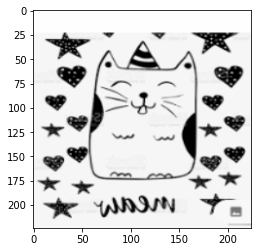

In [11]:
# Checking contents:
plt.imshow(dataset_train[46][0].permute(1,2,0))

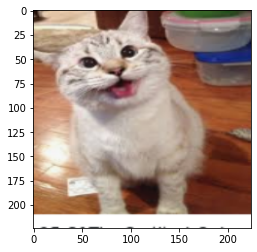

In [12]:
# Checking contents:
plt.imshow(dataset_test[46][0].permute(1,2,0))

In [48]:
#dataset_test_correctlabel=[(sample,label-1) for sample,label in dataset_test]
#dataset_train_correctlabel=[(sample,label-1) for sample,label in dataset_train]

In [13]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=True)

In [15]:
model = models.resnet18(pretrained=True)

In [16]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [17]:
model.fc = nn.Linear(model.fc.in_features, 4)
torch.nn.init.xavier_uniform_(model.fc.weight)

Parameter containing:
tensor([[-0.0748, -0.0296,  0.0029,  ..., -0.1036, -0.0497, -0.0511],
        [ 0.0321, -0.0722, -0.1035,  ...,  0.0939, -0.0367, -0.0934],
        [ 0.0939, -0.0358,  0.0934,  ..., -0.0274, -0.0820,  0.0690],
        [-0.0469,  0.0253, -0.0348,  ..., -0.0754, -0.0392, -0.0649]],
       requires_grad=True)

In [18]:
torch.cuda.device_count()

1

In [19]:
device = torch.device('cuda:0')
model = model.to(device)

In [20]:
# Created class that takes learning rate, momentum factor, learning rate scheduler, and minibatch size to easily change variables and experiment for Task 5
class TransferLearning:


   def __init__(self, learning_rate, momentum_factor, learning_rate_scheduler, minibatch_size, stepSize):
     self.criterion = nn.CrossEntropyLoss()
     self.optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_factor)
     self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=stepSize, gamma=learning_rate_scheduler)
     self.loss_test = 0;
     self.epoch_num = 0;
  
   def run_test(self, model):
     nsamples_test = len(dataset_test)
     loss, correct = 0, 0
     model.eval()
     with torch.no_grad():
         for samples, labels in loader_test:
             samples = samples.to(device)
             labels = labels.to(device)
             outs = model(samples)
             loss += self.criterion(outs, labels)
             _, preds = torch.max(outs.detach(), 1)
             correct_mask = preds == labels
             correct += correct_mask.sum(0).item()
     return loss / nsamples_test, correct / nsamples_test

   def run_train(self, model):
     nsamples_train = len(dataset_train)
     loss_sofar, correct_sofar = 0, 0
     model.train()
     with torch.enable_grad():
         for samples, labels in loader_train:
             samples = samples.to(device)
             labels = labels.to(device)
             self.optimizer.zero_grad()
             outs = model(samples)
             _, preds = torch.max(outs.detach(), 1)
             loss = self.criterion(outs, labels)
             loss.backward()
             self.optimizer.step()
             loss_sofar += loss.item() * samples.size(0)
             correct_sofar += torch.sum(preds == labels.detach())
     self.scheduler.step()
     return loss_sofar / nsamples_train, correct_sofar / nsamples_train

   def run_all(self, model, n_epochs):
     for epoch in range(n_epochs):
         loss_train, acc_train = self.run_train(model)
         self.loss_test, acc_test = self.run_test(model)
         print(f"epoch {self.epoch_num + epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {self.loss_test:.4f} acc {acc_test:.4f}")
     self.epoch_num = self.epoch_num + n_epochs

In [21]:
# accuracy without training
learn = TransferLearning(0.0005, 0.9, 0.1, 10, 4)
learn.run_test(model)

(tensor(0.4950, device='cuda:0'), 0.18625277161862527)

In [22]:
learn.run_all(model, 10)
prev_loss = learn.loss_test

while True:
  learn.run_all(model, 1)
  loss_difference = prev_loss - learn.loss_test
  if (learn.epoch_num > 20):
    break
  prev_loss = learn.loss_test

epoch 0: train loss 1.3132 acc 0.4836, test loss 0.3120 acc 0.5277
epoch 1: train loss 0.8451 acc 0.6724, test loss 0.2064 acc 0.6918
epoch 2: train loss 0.6144 acc 0.7740, test loss 0.2029 acc 0.7184
epoch 3: train loss 0.4819 acc 0.8201, test loss 0.2057 acc 0.7295
epoch 4: train loss 0.3178 acc 0.8895, test loss 0.1446 acc 0.7849
epoch 5: train loss 0.2621 acc 0.9123, test loss 0.1476 acc 0.7783
epoch 6: train loss 0.2122 acc 0.9278, test loss 0.1400 acc 0.7938
epoch 7: train loss 0.2164 acc 0.9284, test loss 0.1635 acc 0.7761
epoch 8: train loss 0.1934 acc 0.9400, test loss 0.1400 acc 0.7960
epoch 9: train loss 0.2029 acc 0.9317, test loss 0.1519 acc 0.7982
epoch 10: train loss 0.1939 acc 0.9395, test loss 0.1381 acc 0.7982
epoch 11: train loss 0.1627 acc 0.9417, test loss 0.1474 acc 0.7827
epoch 12: train loss 0.2144 acc 0.9278, test loss 0.1362 acc 0.7938
epoch 13: train loss 0.1665 acc 0.9484, test loss 0.1517 acc 0.7871
epoch 14: train loss 0.1861 acc 0.9406, test loss 0.1495 a

Optimizing Parameters:

* Top section of the table contains optimized parameters that are compatible with our app integration model

* Bottom section of the table contains overall optimized parameters (not necessarily compatible with app)

| learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch |
|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| ...           | ...      | ...       | ...   | ...       | ...       | ...      | ...        |
| **0.0005** | **0.9** | **8** | **0.1** | 1 | 0.2718  | 0.7035| 14
| **0.0005** | **0.9** | **8** | 0.9 | 1 | 0.3730  | 0.6504| 10
| **0.0005** | **0.9** | **8** | 0.5 | 1 | 0.3148  | 0.6770| 9
| **0.0005** | **0.9** | 4 | 0.1 | 1 | 0.2684  | 0.6504| 10
| **0.0005** | **0.9** | 12 | 0.1 | 1 | 0.3088  | 0.6726| 17
| **0.0005** | **0.9** | 10 | 0.1 | 1 | 0.3179  | 0.6681| 19
| **0.0005** | **0.9** | 5 | 0.1 | 1 | 0.2794  | 0.6637| 16
| **0.0005** | 0.5 | **8** | 0.1 | 1 | 0.2414  | 0.6593 | 6
| **0.0005** | 0.2 | **8** | 0.1 | 1 | 0.2622  | 0.6239 | 13
| 0.005 | **0.9** | **8** | 0.1 | 1 | 0.4175  | 0.4248 | 10
| 0.01 | **0.9** | **8** | 0.1 | 1 | 0.3620  | 0.3850 | 12
| 0.000001 | **0.9** | **8** | 0.1 | 1 | 0.3788 | 0.3496 | 12
| 0.1 | **0.9** | **8** | 0.1 | 1 | 0.3922 | 0.3142 | 19
| 0.001 | **0.9** | **8** | 0.1 | 1 | 0.3316 | 0.6549 | 11
| ... | ... | ... | ... | ... | ... | ... | ... |
| 0.001 | 0.9 | 8 | 0.1 | 5 | 0.3408 | 0.6637 | 20
| 0.1 | 0.9 | 8 | 0.1 | 5 | 0.3492 | 0.4027 | 12
| 0.000001 | 0.9 | 8 | 0.1 | 5 | 0.4359 | 0.3363 | 20
| 0.01 | 0.9 | 8 | 0.1 | 5 | 0.3217 | 0.4292 | 20
| 0.005 | 0.9 | 8 | 0.1 | 5 | 0.3417 | 0.4381 | 8
| **0.0005** | 0.5 | 8 | 0.1 | 5 | 0.2521 | 0.6062 | 11
| **0.0005** | 0.2| 8 | 0.1 | 5 | 0.2577 | 0.6239 | 14
| **0.0005** | 0.8| 8 | 0.1 | 5 | 0.2682 | 0.6681 | 11
| **0.0005** | **0.9** | 5 | 0.1 | 5 | 0.3160 | 0.6549 | 19
| **0.0005** | **0.9** | 10 | 0.1 | 5 | 0.2862 | 0.6858 | 14
| **0.0005** | **0.9** | 12 | 0.1 | 5 | 0.3171 | 0.6637 | 16
| **0.0005** | **0.9** | **8** | 0.5 | 5 | 0.3367 | 0.6726 | 17
| **0.0005** | **0.9** | **8** | 0.9 | 5 | 0.3137 | 0.6504 | 11
| **0.0005** | **0.9** | **8** | **0.1** | 5 | 0.2966 | 0.6903 | 20
| **0.0005** | **0.9** | **8** | **0.1** | 8 | 0.3185 | 0.6549 | 14
| **0.0005** | **0.9** | **8** | **0.1** | 3 | 0.2908 | 0.6814 | 11
| **0.0005** | **0.9** | **8** | **0.1** | 2 | 0.2872 | 0.6504 | 10
| **0.0005** | **0.9** | **8** | **0.1** | **4** | 0.2834 | 0.7168 | 20


May use transforms.Rotation/VerticalFlip/... 

In [ ]:
# Code taken from tutorial video at https://www.youtube.com/watch?v=5Lxuu16_28o&ab_channel=PyTorch

# model.qconfig = torch.quantization.get_default_qconfig('qnnpack')

In [ ]:
# torch.quantization.prepare(model,inplace=True)

In [ ]:
# def calibrate(model,calibration_data):
#   return
# calibrate(model, [])

In [ ]:
# model_quant = torch.quantization.QuantStub()

In [ ]:
# model = torch.quantization.convert(model_quant,inplace=True)

- cpu_model = gpu_model.cpu()
- sample_input_cpu = sample_input_gpu.cpu()
- traced_cpu = torch.jit.trace(traced_cpu, sample_input_cpu)
- torch.jit.save(traced_cpu, "cpu.pth")

In [23]:
cpu_model = model.cpu()
example = torch.rand(1, 3, 224, 224)
traced_cpu = torch.jit.trace(cpu_model, example)
torch.jit.save(traced_cpu, "cpu_model.pt")

In [ ]:
#  torchscript_model = torch.jit.script(model)

In [ ]:
# torchscript_model_optimized = optimize_for_mobile(torchscript_model)

In [ ]:
# model.eval()

In [ ]:
# # example = torch.rand(1, 3, 224, 224)
# traced_script_module = torch.jit.script(model)
# traced_script_module.save("model.pt")

In [ ]:
# example

In [ ]:
# torch.jit.save(torchscript_model_optimized, 'image_model.pt')

In [ ]:
# i = 0
# for samples,labels in loader_test:
#   s = (samples)
#   l = labels
#   samples = samples.to(device)
#   s = samples
#   out = model(samples)
#   i+= 1
#   if i == 11:
#     break

In [ ]:
# out

In [ ]:
# model.eval()

In [ ]:
# s.shape

In [ ]:
# l

In [ ]:
# s.shape

In [ ]:
# out.shape

In [ ]:
# t,p = torch.max(out,1)

In [ ]:
# t.shape

In [ ]:
# p.shape

In [ ]:
# p.to(device)

In [ ]:
torch.sum(p== l.detach())

In [ ]:
out = model(s)

In [ ]:
out

In [ ]:
out.detach()